# U1 Actividad NLP

En esta actividad se ha analizado el conjunto de datos de [OpinRankDatasetWithJudgments](http://kavita-ganesan.com/entity-ranking-data/) para hallar las respuestas a las preguntas que propone el enunciado.

Primero, nos descargamos el dataset:

In [1]:
# If you haven't downloaded the dataset, then uncomment and run. Note unzipping is os dependent
# !curl https://github.com/kavgan/OpinRank/raw/master/OpinRankDatasetWithJudgments.zip -o "data/OpinRankDatasetWithJudgments.zip"
# !7z x -y "data/OpinRankDatasetWithJudgments.zip" -odata # 7zip / windows
# !unzip "data/OpinRankDatasetWithJudgments.zip" # mac

In [2]:
from ipyparallel import Client
rc = Client()

## Lectura de datos

Dentro del zip que hemos descargados encontramos la siguiente estructura de ficheros:

- data (dir)
  - cars (dir)
  - hotels (dir)
    - data (dir)
      - city-name (dir)
        - hotel-name (file)
          - *reviews here*
      - city-name.csv (file)
        - *hotels information*
    - judgments
      - city-name

Ignoramos los datos de coches, directorio `cars`, y nos centraremos en el directorio `hotels`. Dentro de `hotels` encontramos dos directorios, `data` y `judgments`. 

En el primer directorio, data, encontramos los datos sin procesar. Estos datos se agrupan por ciudades. Cada ciudad tiene un fichero `.csv` y un directorio con su nombre. En el csv encontramos la lista de hoteles de esa ciudad y datos asociados a estos. Entre estos datos destaca el atributo `doc_id`, que contiene el nombre del fichero donde se encuentran las review de los usuarios. El fichero de las review se encuentra dentro del directorio con el nombre de la ciudad a la que pertenece.

El `judgments` encontramos un directorio por cada ciudad. Dentro de cada directorio encontramos los resultados de las puntuaciones de relevancia.

Para información más detallada podéis consultar la documentación del dataset, `OpinRankDatasetWithJudgments.pdf`.

In [3]:
import os
import functools
import numpy as np
import pandas as pd

hotels = pd.DataFrame()

# Podemos iterar y unir todos los csv porque sabemos que solo hay 10 ciudades.
# Alternativamente, usariamos una función para cargar cada ciudad de forma independiente 
# como se ha hecho con las review de cada hotel.
for name in os.listdir("data/hotels/data"):
    if name.endswith(".csv"):
      hotelTmp = pd.read_csv(f"data/hotels/data/{name}", delimiter=',', index_col=False)
      hotels = pd.concat([hotels, hotelTmp], axis=0)

# Guardamos todos los nombres de las ciudades
cities = hotels.city.unique()

hotels.head()

,doc_id,hotel_name,hotel_url,street,city,state,country,zip,class,price,num_reviews,CLEANLINESS,ROOM,SERVICE,LOCATION,VALUE,COMFORT,overall_ratingsource
0,china_beijing_holiday_inn_central_plaza,holiday inn central plaza,http://www.tripadvisor.com/ShowUserReviews-g29...,no.1 caiyuan street xuanwu district,beijing,-1,China,100053,-1,-1,247,4.786408,4.631068,4.733010,3.553398,4.699029,0.0,4.480583
1,china_beijing_hilton_beijing_wangfujing,hilton beijing wangfujing,http://www.tripadvisor.com/ShowUserReviews-g29...,no.8 wangfujing east street dongcheng,beijing,-1,China,100006,-1,-1,74,4.810345,4.844828,4.758621,4.827586,4.517241,0.0,4.751724
2,china_beijing_hotel_g,hotel g,http://www.tripadvisor.com/ShowUserReviews-g29...,a7 worker's stadium chaoyang district,beijing,-1,China,100020,-1,-1,110,4.769231,4.750000,4.576923,4.375000,4.653846,0.0,4.625000
3,china_beijing_the_regent_beijing,the regent beijing,http://www.tripadvisor.com/ShowUserReviews-g29...,no.99 jinbao street dongcheng district,beijing,-1,China,100005,-1,-1,111,4.625000,4.812500,4.437500,4.645833,4.531250,0.0,4.610417
4,china_beijing_the_st_regis_beijing,the st regis beijing,http://www.tripadvisor.com/ShowUserReviews-g29...,no.21jianguomenwai street chaoyang district,beijing,-1,China,100020,-1,-1,89,4.846154,4.646154,4.615385,4.492308,4.184615,0.0,4.556923


Como hay muchas reviews vamos a cargar el listado de reviews de cada hotel a demanda.

In [4]:
%%px
# from textblob import TextBlob
# def spellcheck(inputText):
#   blob = TextBlob(str(inputText))
#   return str(blob.correct())

# Dada una fila/row del dataframe hotels del apartado anterior, nos devuelve un dataframe con las reviews
def getReviews(hotel):
  docId = hotel["doc_id"]
  city = hotel["city"].replace(" ", "-")
  fileName = f"data/hotels/data/{city}/{docId}"
  try:
    reviews = pd.read_csv(fileName, delimiter="\t", index_col=False, header=None, encoding="cp1252", on_bad_lines='skip')
    reviews.columns = ["date", "title", "review", "empty"]

    # la columna de date no la vamos a usar y la ultima columna, empty, es resultado de tener un tabulador
    # a final de cada linea. No hay datos. Por lo tanto las quitamos
    reviews = reviews.drop(columns=["date", "empty"]) 

    # corregir ortografía. Es muuuuy lento
    # reviews["title"] = reviews["title"].apply(spellcheck)
    # reviews["review"] = reviews["review"].apply(spellcheck)

    return reviews
  except FileNotFoundError:
    return pd.DataFrame()
  except Exception as e:
    print(e)
    return pd.DataFrame()

In [5]:
%%px --targets 0
# test the function
reviews = getReviews(hotels.iloc[0])
print(f"cantidad de reviews: {len(reviews)}")
reviews.head()

[stdout:0] cantidad de reviews: 247


,title,review
0,Absolutely fantastic. The only negative is not...,Just about everything about this hotel is fant...
1,BEST PLACE FOR TRAVELERS,it was so good to 2 nights when i was at beiji...
2,Excellent and travel advice,"I think this Hotel is very nice, I do not see ..."
3,good place to stay,"just back from Beijing we stayed 4 nights, hot..."
4,Hidden Gem,After reading many positive reviews on Tripadv...


En el proceso de carga de las reviews vimos que los ficheros que contienen las review:
- Tienen una review por fila.
- El separador es un tabulador.
- El encode del fichero es `cp1252`. Se puede abrir en `utf-8` y es legible excepto acentos y algunos caracteres especiales.

En el ejemplo podemos comprobar que la columna `date` no siempre va a tener valor.

Actualización:
  - Se ha modificado el algoritmo para que incluya soporte para corregir typos y se ha quitado la columna `date` ya que no aporta valor.
  - Se ha comentado el corrector. Se tarda en mi maquina unos 10minutos para obtener 250 reviews. Sin el corrector son 0.6s.

## 1. ¿Qué partes de una habitación son las más mencionadas?

In this section, I'm going to use wordnet of each room to look for matches. First, I'm going to look for the definition of room that we need. Then use it's hyponyms to search in the reviews.

In [6]:
%%px
# load dependencies
import re
# import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('universal_tagset')
# nltk.download("punkt")
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pprint

lemmatizer = WordNetLemmatizer()

In [7]:
%%px --target 0
# check the room definition that we need
for sense in wordnet.synsets('room'):
    print(sense)
    print(sense.definition())
    print(sense.examples())
    print("-"*10)

# Synset('room.n.01') is the definition that I'm looking for

[stdout:0] Synset('room.n.01')
an area within a building enclosed by walls and floor and ceiling
['the rooms were very small but they had a nice view']
----------
Synset('room.n.02')
space for movement
['room to pass', 'make way for', 'hardly enough elbow room to turn around']
----------
Synset('room.n.03')
opportunity for
['room for improvement']
----------
Synset('room.n.04')
the people who are present in a room
['the whole room was cheering']
----------
Synset('board.v.02')
live and take one's meals at or in
['she rooms in an old boarding house']
----------


In [8]:
%%px --target 0
room = wordnet.synset('room.n.01')
room.hyponyms()

Out[0:98]: 
[Synset('anechoic_chamber.n.01'),
 Synset('anteroom.n.01'),
 Synset('back_room.n.01'),
 Synset('ballroom.n.01'),
 Synset('barroom.n.01'),
 Synset('bathroom.n.01'),
 Synset('bedroom.n.01'),
 Synset('belfry.n.02'),
 Synset('billiard_room.n.01'),
 Synset('boardroom.n.01'),
 Synset('cardroom.n.01'),
 Synset('cell.n.06'),
 Synset('cell.n.07'),
 Synset('chamber.n.03'),
 Synset('checkroom.n.01'),
 Synset('classroom.n.01'),
 Synset('clean_room.n.01'),
 Synset('cloakroom.n.02'),
 Synset('closet.n.04'),
 Synset('clubroom.n.01'),
 Synset('compartment.n.02'),
 Synset('conference_room.n.01'),
 Synset('control_room.n.01'),
 Synset('court.n.02'),
 Synset('cubby.n.01'),
 Synset('cutting_room.n.01'),
 Synset('darkroom.n.01'),
 Synset('den.n.04'),
 Synset('dinette.n.01'),
 Synset('dining_room.n.01'),
 Synset('door.n.05'),
 Synset('dressing_room.n.01'),
 Synset('durbar.n.01'),
 Synset('engineering.n.03'),
 Synset('floor.n.10'),
 Synset('furnace_room.n.01'),
 Synset('gallery.n.03'),
 Synset('g

Estas funciones nos servirán para lanzar y recuperar los procesos en paralelo

In [43]:
import functools

# reduce function
def concatCounter(dict1, dict2):
  try:
    for key in dict1.keys():
      if key in dict2:
        dict2[key] += dict1[key]
      else:
        dict2[key] = dict1[key]
    return dict2
  except:
    if dict(dict1):
      return dict1
    else:
      if dict(dict2):
        return dict2
      else:
        return {}

def parallelize_dataframe(df, func, reduceFunc):
  df_split = np.array_split(df, os.cpu_count())
  # get a view on the cluster
  view = rc.load_balanced_view()
  # submit the tasks
  asyncresult = view.map_async(func, df_split)
  # wait interactively for results
  asyncresult.wait_interactive()
  # retrieve actual results
  result = functools.reduce(reduceFunc,asyncresult.get())
  return result

Las funciones a continuación serán usadas en cada thread / cluster.
En el primer bloque hay las genéricas.
En el segundo bloque las funciones de búsqueda de habitaciones

In [10]:
%%px 
def addOne(dict, key):
  if key in dict:
    dict[key] += 1
  else:
    dict[key] = 1
  return dict

def getNouns(review):
  nouns = []
  cleanText = wordCleaner(review)
  tokens = list(set(word_tokenize(cleanText)))
  taggedTokens = pos_tag(tokens, tagset='universal')
  for taggedToken in taggedTokens:
    (word, tokenType) = taggedToken
    if tokenType == "NOUN":
      nouns.append(word)
  return nouns

def wordCleaner(text):
  return re.sub("(\W(?!(\w)))+", " ", str(text)).lower()

def getSynsetsNames(synsets):
  return list(map(lambda synset: synset.name(), synsets))

rooms = getSynsetsNames(wordnet.synset('room.n.01').hyponyms()) # get room names as "constant", so we don't recalculate every time

In [11]:
%%px
def processReview(counter, review):
  text = str(review.title) + " " + str(review.review)
  tokenizedText = getNouns(text)
  for word in tokenizedText:
    try:
      roomType = getRoomType(word)
      if roomType != None:
        counter = addOne(counter, roomType)
    except Exception as e:
      print(f"failed with word '{word}' with type '{roomType}' and error code: {e}")
  return counter

def getRoomType(word):
  wordSynsets = wordnet.synsets(str(word))
  for wordSynset in getSynsetsNames(wordSynsets):
    if wordSynset in rooms:
      return wordSynset
  return None

La función `findAllRoomMentions` al ser la principal la definimos en local porque debe ser visible para la función `map` (dentro de `parallelize_dataframe`) y enviarla al cluster a ejecutar.

In [12]:
def findAllRoomMentions(hotels):
  counter = {}
  for index, hotel in hotels.iterrows():
    reviews = getReviews(hotel)
    for reviewIdx, review in reviews.iterrows():
      counter = processReview(counter, review)
  return counter

Usamos 12 hoteles para probar que los resultados son los que queremos.

In [13]:
# test
parallelize_dataframe(hotels[0:12], findAllRoomMentions, concatCounter)

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

{'bathroom.n.01': 233,
 'door.n.05': 102,
 'anteroom.n.01': 101,
 'lounge.n.02': 84,
 'cell.n.06': 21,
 'kitchen.n.01': 7,
 'bedroom.n.01': 24,
 'toilet.n.01': 36,
 'classroom.n.01': 1,
 'sun_parlor.n.01': 1,
 'barroom.n.01': 142,
 'floor.n.10': 167,
 'court.n.02': 8,
 'gallery.n.03': 4,
 'closet.n.04': 8,
 'walk-in.n.04': 4,
 'cubby.n.01': 1,
 'living_room.n.01': 1,
 'study.n.05': 4,
 'library.n.01': 1,
 'engineering.n.03': 1}

Ejecutamos el proceso para todos los hoteles agrupados por ciudad

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findAllRoomMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

<AxesSubplot:>

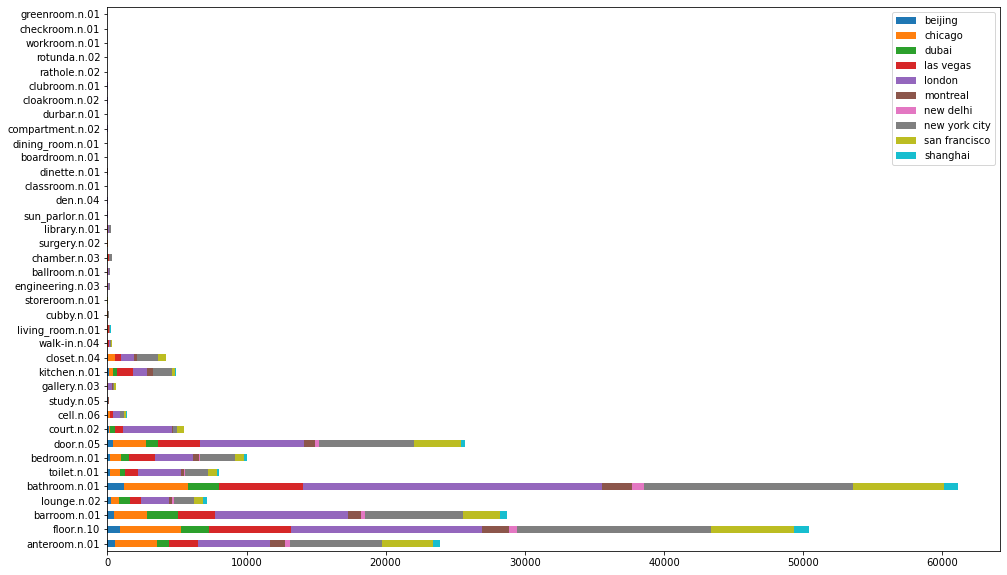

In [14]:
stats = {}

for city in cities:
  stats[city] =  parallelize_dataframe(hotels[hotels["city"] == city], findAllRoomMentions, concatCounter)

statsDf = pd.DataFrame(stats).replace('NaN', 0)
statsDf.to_csv('resultados_apartado_1.csv')
statsDf.plot.barh(figsize=(16,10), stacked=True)

### Resultados

## 2. ¿Qué servicios pueden detectarse por cada hotel?
Ejecutamos el mismo código de búsqueda anterior mortificándolo para que esta vez busque servicios.

Antes de que pueda buscar servicios debemos definir cuales son los *synset* de los servicios de un hotel.

In [ ]:
%%px --target 0
# buscar las definiciones de "que es un servicio"
hotelServices = ["restaurant", "pool", "spa", "gym", "bellman", "wifi", "television", "excursion", "clean", "hotspot"]
for service in hotelServices:
  for sense in wordnet.synsets(service)[0:3]:
      print(sense)
      print(sense.definition())
      print(sense.examples())
      print(sense.hyponyms())
      print(sense.hypernyms())
      print("-"*10)

[stdout:0] Synset('restaurant.n.01')
a building where people go to eat
[]
[Synset('bistro.n.01'), Synset('brasserie.n.01'), Synset('brewpub.n.01'), Synset('cafe.n.01'), Synset('cafeteria.n.01'), Synset('canteen.n.03'), Synset('canteen.n.05'), Synset('diner.n.03'), Synset('greasy_spoon.n.01'), Synset('grillroom.n.01'), Synset('hash_house.n.01'), Synset('lunchroom.n.01'), Synset('rotisserie.n.02'), Synset('steakhouse.n.01'), Synset('teashop.n.01')]
[Synset('building.n.01')]
----------
Synset('pool.n.01')
an excavation that is (usually) filled with water
[]
[Synset('cistern.n.03'), Synset('swimming_pool.n.01'), Synset('wading_pool.n.01'), Synset('water_jump.n.01')]
[Synset('excavation.n.03')]
----------
Synset('pond.n.01')
a small lake
['the pond was too small for sailing']
[Synset('fishpond.n.01'), Synset('horsepond.n.01'), Synset('mere.n.01'), Synset('millpond.n.01'), Synset('swimming_hole.n.01'), Synset('water_hole.n.01')]
[Synset('lake.n.01')]
----------
Synset('pool.n.03')
an organiz

Los servicios que hemos seleccionado son los siguientes:
- service.n.15: 
- restaurant.n.01: a building where people go to eat
- pool.n.01: an excavation that is (usually) filled with water
- watering_place.n.01: a health resort near a spring or at the seaside
- athletic_facility.n.01: a facility for athletic events
- baggageman.n.01: an attendant who takes care of baggage
- bellboy.n.01: someone employed as an errand boy and luggage carrier around hotels
- lifeguard.n.01: an attendant employed at a beach or pool to protect swimmers from accidents
- checker.n.01: an attendant who checks coats or baggage
- houseclean.v.01: clean and tidy up the house. Se ha buscado esta definición para tratar de obtener resultados sobre el servicio de limpieza
- wireless_local_area_network.n.01: si el hotel tiene wifi
- television.n.01: si el hotel tiene televisores en las habitaciones
- excursion.n.01: si el hotel ofrece excursiones organizadas
- gambling_house.n.01: si el hotel tiene un casino o salon de juegos
- health_spa.n.01: si el hotel tiene un spa
- hotel-casino.n.01: otra definición para saber si el hotel tiene un casino o salon de juegos
- massage_parlor.n.02: si hay masajistas
- mercantile_establishment.n.01: el hotel tiene una tienda o zona de tiendas cerca
- spot.n.07: ubicaciones populares cercanas

In [16]:
%%px
services = [
  wordnet.synset('service.n.15'), # el servicio que da un camarero a los clientes
  wordnet.synset('restaurant.n.01'),
  wordnet.synset('pool.n.01'),
  wordnet.synset('watering_place.n.01'), # kinda spa
  wordnet.synset('athletic_facility.n.01'),
  wordnet.synset('baggageman.n.01'),
  wordnet.synset('bellboy.n.01'),
  wordnet.synset('lifeguard.n.01'),
  wordnet.synset('checker.n.01'),
  wordnet.synset('houseclean.v.01'),
  wordnet.synset('wireless_local_area_network.n.01'),
  wordnet.synset('television.n.01'),
  wordnet.synset('excursion.n.01'),
  wordnet.synset('gambling_house.n.01'), 
  wordnet.synset('health_spa.n.01'), 
  wordnet.synset('hotel-casino.n.01'), 
  wordnet.synset('massage_parlor.n.02'), 
  wordnet.synset('mercantile_establishment.n.01'),
  wordnet.synset('spot.n.07'),
]
serviceNames = getSynsetsNames(services)

Creamos la función `getAllHypernyms` capaz de calcular todos los *hypernyms* dada una palabra

In [17]:
%%px
from collections import OrderedDict

def removeDuplicates(list):
  return OrderedDict.fromkeys(list).keys()

def getAllHypernyms(itemName):
  allItemHypernyms = []
  for synset in wordnet.synsets(itemName):
    allItemHypernyms = allItemHypernyms + getAllHypernymsOsSynset(synset)
  return removeDuplicates(allItemHypernyms)

def getAllHypernymsOsSynset(synset):
  synsetHypernyms = synset.hypernyms()
  if len(synsetHypernyms) == 0:
    return []

  allSynsetHypernyms = []
  for hypernym in synsetHypernyms:
    allSynsetHypernyms = allSynsetHypernyms + getAllHypernymsOsSynset(hypernym)

  return synsetHypernyms + allSynsetHypernyms

In [18]:
%%px --target 0
# test
pprint.pprint(getAllHypernyms('restaurant'))

[stdout:0] odict_keys([Synset('building.n.01'), Synset('structure.n.01'), Synset('artifact.n.01'), Synset('whole.n.02'), Synset('object.n.01'), Synset('physical_entity.n.01'), Synset('entity.n.01')])


Procedimiento de búsqueda

In [19]:
%%px
def lookForServices(counter, review):
  text = str(review.title) + " " + str(review.review)
  tokenizedText = getNouns(text)
  for word in tokenizedText:
    try:
      serviceType = getServiceType(word)
      if serviceType != None:
        counter = addOne(counter, word)
    except Exception as e:
      print(e)
  return counter

# En este caso en lugar de mirar si los synset de 1 nivel encajan con la lista de habitaciones posibles, vamos a hacerlo al revés.
# Vamos a coger todos los hypernyms de la palabra y ver si encaja 
def getServiceType(word):
  wordSynsets = getAllHypernyms(word)
  for wordSynset in getSynsetsNames(wordSynsets):
    if wordSynset in serviceNames:
      return wordSynset
  return None

In [38]:
def findAllServices(hotels):
  counterList = {}
  for index, hotel in hotels.iterrows():
    reviews = getReviews(hotel)
    counter = {}
    for reviewIdx, review in reviews.iterrows():
      lookForServices(counter, review)
    counterList[hotel["hotel_name"]] = counter
  return counterList

# test
result = parallelize_dataframe(hotels[0:12], findAllServices, concatCounter)
pd.DataFrame(result).head()

findAllServices:   0%|          | 0/12 [00:00<?, ?tasks/s]

,spring garden courtyard hotel,michael s house in beijing,intercontinental financial street beijing,double happiness courtyard hotel,the opposite house,the ritz carlton huamao center,park plaza beijing wangfujing,the st regis beijing,the regent beijing,hotel g,hilton beijing wangfujing,holiday inn central plaza
shops,1.0,1.0,NaN,5.0,3.0,2.0,12.0,1.0,1.0,2.0,7.0,3.0
stand,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,2.0
market,1.0,2.0,NaN,1.0,1.0,NaN,24.0,7.0,6.0,6.0,12.0,6.0
cable,NaN,1.0,NaN,2.0,NaN,NaN,9.0,NaN,1.0,NaN,1.0,NaN
shop,NaN,1.0,NaN,1.0,NaN,NaN,5.0,1.0,2.0,1.0,1.0,6.0


In [41]:
result = parallelize_dataframe(hotels, findAllServices, concatCounter)
result = {k: v for k, v in result.items() if v} # remove empty results

resultDf = pd.DataFrame(result).transpose()
resultDf.to_csv('resultados_apartado_2.csv')
resultDf.head()

findAllServices:   0%|          | 0/12 [00:00<?, ?tasks/s]

,mall,stands,market,supermarket,stores,plaza,store,stall,center,sinks,...,supermarkets,salon,bakery,teashop,boutique,plazas,groceries,clubs,cafe,hotspots
hilton beijing wangfujing,12.0,1.0,12.0,6.0,3.0,4.0,2.0,3.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday inn central plaza,3.0,NaN,6.0,2.0,2.0,54.0,2.0,NaN,12.0,NaN,...,5.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Resultados

Los servicios encontrados en las review de cada hotel no tiene porque ser del propio hotel.

Comentar también que el synset de 'pool.n.01' puesto para detectar si el hotel tiene o no piscina, ha terminado detectando si hay desagües (sink/s)

## 3. ¿Qué lugares y qué porcentaje de revisiones sobre cada ciudad mencionan otras ciudades, regiones o puntos de interés turístico?

En este apartado en lugar de usar nltk vamos a usar spacy. Spacy, durante la tokenización nos etiqueta el tipo de palabra que es. En nuestro caso buscaremos por las palabras que se etiqueten como `GPE`, "Geopolitical entity, i.e. countries, cities, states".

In [25]:
%%px
import spacy
nlp = spacy.load("en_core_web_sm")

In [31]:
def findGpeMentions(hotels):
  gpeMentions = {}
  for index, hotel in hotels.iterrows():
    reviews = getReviews(hotel)
    for reviewIdx, review in reviews.iterrows():
      text = str(review.title) + ". " + str(review.review)
      tokens = nlp(text)
      for ent in tokens.ents:
        if ent.label_ == "GPE":
          gpeMentions = addOne(gpeMentions, ent.lower_)
      gpeMentions = addOne(gpeMentions, "reviewsAnalyzed")
  return gpeMentions

#test
test_result = {}
test_result["test_city"] = parallelize_dataframe(hotels[10:12], findGpeMentions, concatCounter)
pd.DataFrame.from_dict(test_result).fillna(0).head()

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

,test_city
beihai park,1
beiing,1
beijing,65
china,19
forbidden city,1


In [32]:
allGpeMentions = {}

for city in cities:
  allGpeMentions[city] = parallelize_dataframe(hotels[hotels["city"] == city], findGpeMentions, concatCounter)

allGpeMentionsDf = pd.DataFrame.from_dict(allGpeMentions).fillna(0)
allGpeMentionsDf.to_csv("resultados_apartado_3.csv")
allGpeMentionsDf.head()

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

findGpeMentions:   0%|          | 0/12 [00:00<?, ?tasks/s]

,beijing,chicago,dubai,las vegas,london,montreal,new delhi,new york city,san francisco,shanghai
china,1378.0,25.0,30.0,17.0,141.0,53.0,10.0,194.0,648.0,856.0
forbidden city,323.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
reviewsAnalyzed,5253.0,18053.0,11767.0,26157.0,78896.0,9333.0,4917.0,54659.0,30401.0,4276.0
beijing,3942.0,1.0,2.0,3.0,9.0,2.0,2.0,1.0,1.0,149.0
us,196.0,189.0,133.0,211.0,1368.0,151.0,95.0,662.0,425.0,78.0


### Por ejemplo, con vuestra información podríamos llegar a responder a la pregunta: ¿en Las Vegas se menciona el Gran Cañón del Colorado?
Si, para ello tendríamos que buscar en el resultado de búsqueda `allGpeMentions` por la key, `Las Vegas` y dentro de las menciones de Las Vegas buscar si existe la key `Gran Cañón del Colorado`, en el idoma de las reviews, inglés.
Hay que tener en cuenta que no se corregido el input del usuario, por lo que resultados como "Gran canyon" o "Colorado canyon" aparecerían como sitios distintos.

In [35]:
lasVegasGpe = allGpeMentions.get("las vegas", {})
granCanyonGpe = lasVegasGpe.get("gran canyon", "No se ha encontrado 'gran canyon'")
print(granCanyonGpe)

No se ha encontrado 'gran canyon'


Buscando con regex a mano si he encontrado "gran canyon". A continuación el porqué no se detecta.

In [36]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

# review 320 de usa_nevada_las-vegas_excalibur_hotel_casino
text = "fantastic value for money at the excalibur	My husband and i stayed at the excalibur from the 6th to 16th april we had a wonderful time, this hotel is in a great spot on strip, we were in tower 2 and the room was spotless, cleaned every day, food was great value from buffet bar, staff were very friendly and helpful, if you are going to visit gran canyon book with sundance they are a class act just a fantastic place to visit las vegas cant wait to go back"

train = nlp(text)
displacy.render(train, jupyter=True, style="ent")

Gran canyon se etiqueta como nombre de persona en lugar de una ubicación, `GPE`.